In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import *
from Triangle.Data import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

# import multiprocessing

# np.random.seed(114514)
# xp.random.seed(114514)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


has cupy
has cupy
has BBHx waveform


## $\mathcal{F}$-statistics

In [2]:
import copy 

class Fstatistics(Likelihood):
    extrinsic_parameter_names = [
        "luminosity_distance", 
        "inclination", 
        "coalescence_phase", 
        "psi"
        ]
    intrinsic_parameter_names = [
        'chirp_mass',
        'mass_ratio',
        'spin_1z',
        'spin_2z',
        'coalescence_time',
        'longitude',
        'latitude'
        ]
    def __init__(self, response_generator, frequency, data, invserse_covariance_matrix, response_parameters, use_gpu=False):
        super().__init__(response_generator, frequency, data, invserse_covariance_matrix, response_parameters, use_gpu)
        self.SUM = self.xp.sum 
        self.CONJ = self.xp.conjugate
        self.RE = self.xp.real
        self.NX = self.xp.newaxis 
        self.MATMUL = self.xp.matmul
        self.TRANS = self.xp.transpose

    def self_inner_product_vectorized(self, template_channels):
        """ 
            template_channels: shape (Nevent, Nchannel, Nfreq)
        """
        residual = self.TRANS(template_channels, (0, 2, 1)) # (Nevent, 3, Nf) -> (Nevent, Nf, 3)
        residual_dagger = self.CONJ(residual[:, :, self.NX, :]) # (Nevent, Nf, 1, 3)
        residual = residual[:, :, :, self.NX] # (Nevent, Nf, 3, 1)
        inners = self.SUM(self.MATMUL(self.MATMUL(residual_dagger, self.invserse_covariance_matrix), residual), axis=(1,2,3)) # (Nevent)
        return self.RE(inners) # (Nevent)
    
    def inner_product_vectorized(self, template_channels1, template_channels2):
        """ 
            template_channels1: shape (Nevent, Nchannel, Nfreq)
            template_channels2: shape (Nevent, Nchannel, Nfreq)
        """
        residual1 = self.TRANS(template_channels1, (0, 2, 1)) # (Nevent, 3, Nf) -> (Nevent, Nf, 3)
        residual_dagger1 = self.CONJ(residual1[:, :, self.NX, :]) # (Nevent, Nf, 1, 3)

        residual2 = self.TRANS(template_channels2, (0, 2, 1)) # (Nevent, 3, Nf) -> (Nevent, Nf, 3)
        residual2 = residual2[:, :, :, self.NX] # (Nevent, Nf, 3, 1)

        inners = self.SUM(self.MATMUL(self.MATMUL(residual_dagger1, self.invserse_covariance_matrix), residual2), axis=(1,2,3)) # (Nevent)
        return self.RE(inners) # (Nevent)

    def calculate_Fstat_vectorized(self, intrinsic_parameters, return_a=False, return_recovered_wave=False):
        """  
        calculate F-statistics for a batch of events TODO: expand to HM waveform 
        Args: 
            intrinsic_parameters: dictionary of intrinsic parameters (except for D, iota, phic, psi), each item is a numpy array of shape (Nevent). 
        Returns: 
            F-statistics of events 
        """
        Nevent = len(np.atleast_1d(intrinsic_parameters["chirp_mass"]))
        
        full_parameters1 = copy.deepcopy(intrinsic_parameters)
        full_parameters1["luminosity_distance"] = np.ones(Nevent) * 0.25 
        full_parameters1["coalescence_phase"] = np.zeros(Nevent)
        full_parameters1["inclination"] = np.ones(Nevent) * PI / 2. 
        full_parameters1["psi"] = np.zeros(Nevent)
        # print("1st parameter set:") # TEST 
        # print(full_parameters1) # TEST 

        temp1 = self.response_generator.Response(
            parameters=full_parameters1,
            freqs=self.frequency,
            **self.response_kwargs,
        ) # (Nchannel=3, Nevent, Nfreq)
        
        full_parameters2 = copy.deepcopy(full_parameters1)
        full_parameters2["psi"] = np.ones(Nevent) * PI / 4. 
        # print("2nd parameter set:") # TEST 
        # print(full_parameters2) # TEST 

        temp2 = self.response_generator.Response(
            parameters=full_parameters2,
            freqs=self.frequency,
            **self.response_kwargs,
        ) # (Nchannel=3, Nevent, Nfreq)

        if Nevent == 1:
            temp1 = temp1[:, self.NX, :]
            temp2 = temp2[:, self.NX, :]

        X1 = self.TRANS(temp1, axes=(1, 0, 2)) # (Nevent, Nchannel, Nfreq)
        X2 = 1.j * X1 # (Nevent, Nchannel, Nfreq)
        X3 = self.TRANS(temp2, axes=(1, 0, 2)) # (Nevent, Nchannel, Nfreq)
        X4 = 1.j * X3 # (Nevent, Nchannel, Nfreq) 
        # print("shape of X1:", X1.shape) # TEST 
        
        data_expand = self.data[self.NX, :, :] # (1, Nchannel, Nfreq)
        Nvector = self.TRANS(self.xp.array([
            self.inner_product_vectorized(data_expand, X1), 
            self.inner_product_vectorized(data_expand, X2), 
            self.inner_product_vectorized(data_expand, X3), 
            self.inner_product_vectorized(data_expand, X4), 
        ])) # (4, Nevent) -> (Nevent, 4) inner products, all real numbers 
        # print("shape of N vector:", Nvector.shape) # TEST 
        
        M12 = self.inner_product_vectorized(X1, X2) # (Nevent), real numbers 
        M13 = self.inner_product_vectorized(X1, X3)
        M14 = self.inner_product_vectorized(X1, X4)
        M23 = self.inner_product_vectorized(X2, X3)
        M24 = self.inner_product_vectorized(X2, X4)
        M34 = self.inner_product_vectorized(X3, X4)
        Mmatrix = self.TRANS(self.xp.array([
            [self.self_inner_product_vectorized(X1), M12, M13, M14], 
            [M12, self.self_inner_product_vectorized(X2), M23, M24], 
            [M13, M23, self.self_inner_product_vectorized(X3), M34], 
            [M14, M24, M34, self.self_inner_product_vectorized(X4)]
        ]), axes=(2, 0, 1)) # (4, 4, Nevent) -> (Nevent, 4, 4) inner products, all real numbers 
        # print("shape of M matrix:", Mmatrix.shape) # TEST 
        
        invMmatrix = self.xp.linalg.inv(Mmatrix) # (Nevent, 4, 4)
        
        Nvector_col = Nvector[..., self.NX] # (Nevent, 4, 1)
        NM = self.MATMUL(invMmatrix, Nvector_col) # (Nevent, 4, 1)
        Nvector_row = Nvector[:, self.NX, :] # (Nevent, 1, 4)
        NMN = self.MATMUL(Nvector_row, NM) # (Nevent, 1, 1)
        
        res = 0.5 * NMN[:, 0, 0] # (Nevent) Fstat 0.5 * N^T M^{-1} N
        
        if return_a:
            res_a = NM.squeeze(axis=-1) # (Nevent, 4)
            if self.use_gpu:
                return res_a.get() # (Nevent, 4)
            else: 
                return res_a # (Nevent, 4)
            
        if return_recovered_wave: 
            res_a = NM.squeeze(axis=-1) # (Nevent, 4)
            res_wf = res_a[:, 0] * self.TRANS(X1, axes=(1, 2, 0)) # (Nchannel, Nfreq, Nevent)
            res_wf += res_a[:, 1] * self.TRANS(X2, axes=(1, 2, 0))
            res_wf += res_a[:, 2] * self.TRANS(X3, axes=(1, 2, 0))
            res_wf += res_a[:, 3] * self.TRANS(X4, axes=(1, 2, 0)) 
            return self.TRANS(res_wf, (0, 2, 1)) # (Nchannel, Nevent, Nfreq)

        # else:
        if self.use_gpu:
            return res.get() # (Nevent)
        else: 
            return res 
        
    @staticmethod
    def a_to_extrinsic(a):
        """ 
        TODO: expand to HM waveform 
        Args: 
            a: (Nevent, 4), numpy array of the a coefficients 
        Returns: 
            dictionary of extrinsic parameters 
        """
        extrinsic_parameters = dict()
        
        P = np.linalg.norm(a, axis=1) ** 2 # (Nevent)
        Q = a[:, 1] * a[:, 2] - a[:, 0] * a[:, 3] # (Nevent)
        Delta = np.sqrt(P ** 2 - 4. * Q ** 2) # (Nevent)
        Aplus = np.sqrt((P + Delta) / 2.) # (Nevent)
        Across = np.sign(Q) * np.sqrt((P - Delta) / 2.) # (Nevent)
        
        tmp = Aplus + np.sqrt(Aplus ** 2 - Across ** 2) # (Nevent)
        extrinsic_parameters["luminosity_distance"] = 0.5 / tmp # (Nevent)
        extrinsic_parameters["inclination"] = np.arccos(Across / tmp) # (Nevent)
        extrinsic_parameters["coalescence_phase"] = -np.arctan(2. * (a[:, 0] * a[:, 1] + a[:, 2] * a[:, 3]) / (a[:, 0] ** 2 + a[:, 2] ** 2 - a[:, 1] ** 2 - a[:, 3] ** 2)) / 2. # (Nevent), one possible solution 
        extrinsic_parameters["psi"] = np.arctan(2. * (a[:, 0] * a[:, 2] + a[:, 1] * a[:, 3]) / (a[:, 0] ** 2 + a[:, 1] ** 2 - a[:, 2] ** 2 - a[:, 3] ** 2)) / 4. # (Nevent), one possible solution 
        
        if a.shape[0] == 1:
            extrinsic_parameters_out = dict() 
            for k, v in extrinsic_parameters.items():
                extrinsic_parameters_out[k] = v[0]
            return extrinsic_parameters_out
        else:              
            return extrinsic_parameters
    
    @staticmethod
    def IntParamDict2ParamArr(param_dict):
        return np.array([
            np.log10(param_dict['chirp_mass']),
            param_dict['mass_ratio'],
            param_dict['spin_1z'],
            param_dict['spin_2z'],
            param_dict['coalescence_time'],
            param_dict['longitude'],
            np.sin(param_dict['latitude']),
        ]) # (Nparams, Nevent)

    @staticmethod
    def IntParamArr2ParamDict(params):
        p = dict()
        p['chirp_mass'] = np.power(10., params[0])
        p['mass_ratio'] = params[1]
        p['spin_1z'] = params[2]
        p['spin_2z'] = params[3]
        p['coalescence_time'] = params[4]
        p['longitude'] = params[5]
        p['latitude'] = np.arcsin(params[6])
        return p 

## Data settings 

In [3]:
t_start = 10. * DAY # start time in s
Tobs = 5. * DAY # data length in s 
t_end = t_start + Tobs # end time in s 
dt = 10. # time cadance in s 
fsample = 1. / dt # sampling rate in Hz 
data_frequencies = np.fft.rfftfreq(n=int(Tobs/dt), d=dt) # frequecies where waveform will be calculated 
delta_f = 1. / Tobs

data_frequencies.shape 

(21601,)

In [4]:
# mask the "null" frequencies, which may cause singularity in the calculation of likelihood 
mask = np.ones_like(data_frequencies, dtype=bool)
for i in range(1, 40): 
    mask_idx = np.where(np.abs(data_frequencies - i*0.025)<i*3e-4)[0]
    mask[mask_idx] = False 
data_frequencies = data_frequencies[mask]

# remove the frequencies below Taiji sensitive band 
mask = np.where(data_frequencies > 1e-5)[0]
data_frequencies = data_frequencies[mask]
data_frequencies_GPU = xp.array(data_frequencies)

data_frequencies.shape 

(21077,)

## Set response model 

In [5]:
# the path of Taiji orbit 
orbit_GPU = Orbit(OrbitDir="../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB") # create individial orbit objects for CPU and GPU to avoid the confusion of numpy / cupy orbit data 

# initialize  waveform generator 
WFG_GPU = BBHxWaveformGenerator(mode="primary", use_gpu=True)

# initialize response generator 
FDTDI_GPU = BBHxFDTDIResponseGenerator(orbit_class=orbit_GPU, waveform_generator=WFG_GPU, use_gpu=True)

# response settings 
response_kwargs_GPU = dict(
    modes=[(2,2)], 
    tmin=t_start / DAY, # start time in day 
    tmax=t_end / DAY, # end time in day  
    TDIGeneration="2nd", # "1st" or "2nd"
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
    interpolation=True,
)

## Waveform generation 

In [6]:
mbhb_parameters = {
    'chirp_mass': np.power(10., np.random.uniform(5.5, 6.5)), # [Solar mass], for chirp_mass of 10^5 or smaller, a smaller dt is needed
    'mass_ratio': np.random.uniform(0.1, 1.), 
    'spin_1z': np.random.uniform(-0.99, 0.99),
    'spin_2z': np.random.uniform(-0.99, 0.99),
    'coalescence_time': np.random.uniform(t_start + DAY, t_end) / DAY, # [day], start from t_start to ensure that at least 1-day waveform is within the data
    'coalescence_phase': np.random.uniform(0, TWOPI),
    'luminosity_distance': np.power(10., np.random.uniform(4., 5.)), # [MPC]
    'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
    'longitude': np.random.uniform(0, TWOPI), # [rad]
    'latitude': np.arcsin(np.random.uniform(-1., 1.)), # [rad]
    'psi': np.random.uniform(0, PI) # [rad]
    }
mbhb_parameters

{'chirp_mass': 576197.9514630286,
 'mass_ratio': 0.5522574054088192,
 'spin_1z': 0.37355911773267536,
 'spin_2z': 0.00623924327101133,
 'coalescence_time': 11.274804346596925,
 'coalescence_phase': 5.6659961040911435,
 'luminosity_distance': 18857.206212729037,
 'inclination': 2.236968054828406,
 'longitude': 1.8871744807025843,
 'latitude': 0.371115967075367,
 'psi': 1.7289147577479866}

In [7]:
wf_channels = FDTDI_GPU.Response(mbhb_parameters, data_frequencies_GPU, **response_kwargs_GPU)
wf_channels.shape 

(3, 21077)

## Noise generation 

In [8]:
arm_time = (t_start + t_end) / 2. 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit_GPU.LTTfunctions()[key](arm_time)
# print("arm lengths:", arms)

# theoretical PSDs at the given armlengths 
PSDfunc = TDIPSDs()
PSD_channels = np.array([
    PSDfunc.PSD_A2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_E2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_T2_unequal(data_frequencies, arms)
])

# generate frequency-domain noises as Gaussian and stationary 
Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
noise_channels = xp.array(Re_tmp + 1.j * Im_tmp) 

# covariance matrix 
CovMat = np.array([
    [PSD_channels[0], np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), PSD_channels[1], np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = np.linalg.inv(np.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)
InvCovMat[:, 2, 2] *= 0. # use A, E channels only in the following analysis 

PSD_channels.shape, noise_channels.shape, InvCovMat.shape 

((3, 21077), (3, 21077), (21077, 3, 3))

In [9]:
opt_SNR = FrequencyDomainCovarianceSNR(wf_channels.get(), InvCovMat)
opt_SNR

2842.815615466924

## Data combination 

In [10]:
data_channels = wf_channels + noise_channels 

Text(0, 0.5, 'Frequency-domain data (1/Hz)')

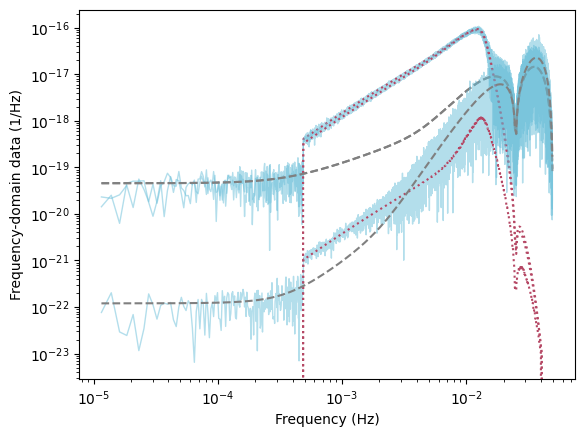

In [11]:
for ichannel, nchannel in enumerate(["A", "E", "T"]): 
    plt.loglog(data_frequencies, np.abs(data_channels[ichannel].get()), linewidth=1, alpha=0.5, color=BLUE)
    plt.loglog(data_frequencies, np.abs(wf_channels[ichannel].get()), color=RED, linestyle=":")
    plt.loglog(data_frequencies, np.sqrt(PSD_channels[ichannel] * Tobs / 2.), color="grey", linestyle="--")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency-domain data (1/Hz)")

## Rapid search phase 

### initialize $\mathcal{F}$-stat and likelihood

In [12]:
Fstat = Fstatistics(
    response_generator=FDTDI_GPU, 
    frequency=data_frequencies_GPU, 
    data=data_channels, 
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_GPU, 
    use_gpu=True 
)

Like = Likelihood(
    response_generator=FDTDI_GPU, 
    frequency=data_frequencies_GPU, 
    data=data_channels,
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_GPU, 
    use_gpu=True,
)

number of freuqncies: 21077
min and max frequencies: 1.1574074074074073e-05 0.04939814814814815
response kwargs: {'modes': [(2, 2)], 'tmin': 10.0, 'tmax': 15.0, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False, 'interpolation': True}
number of freuqncies: 21077
min and max frequencies: 1.1574074074074073e-05 0.04939814814814815
response kwargs: {'modes': [(2, 2)], 'tmin': 10.0, 'tmax': 15.0, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False, 'interpolation': True}


### compare $\mathcal{F}$-stat and likelihood around truths

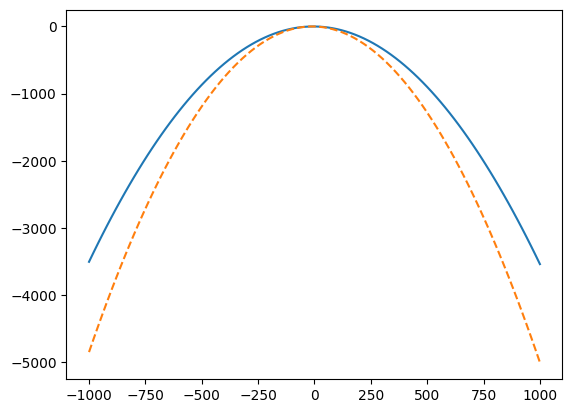

In [13]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["chirp_mass"] = mbhb_parameters["chirp_mass"] + np.linspace(-1000, 1000, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["chirp_mass"] = test_int_params["chirp_mass"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["chirp_mass"] - mbhb_parameters["chirp_mass"], test_F - np.max(test_F))
plt.plot(test_int_params["chirp_mass"] - mbhb_parameters["chirp_mass"], test_L - np.max(test_L), linestyle="--")

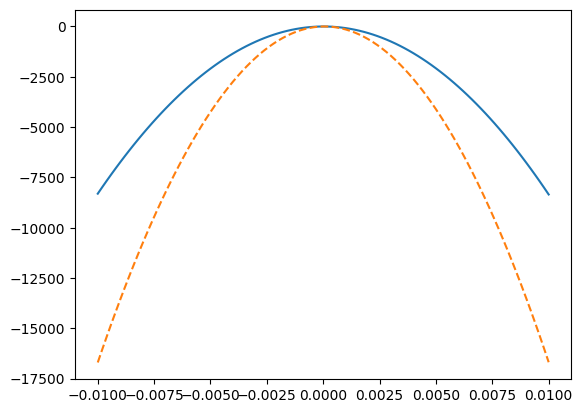

In [14]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["spin_1z"] = mbhb_parameters["spin_1z"] + np.linspace(-0.01, 0.01, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["spin_1z"] = test_int_params["spin_1z"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["spin_1z"] - mbhb_parameters["spin_1z"], test_F - np.max(test_F))
plt.plot(test_int_params["spin_1z"] - mbhb_parameters["spin_1z"], test_L - np.max(test_L), linestyle="--")

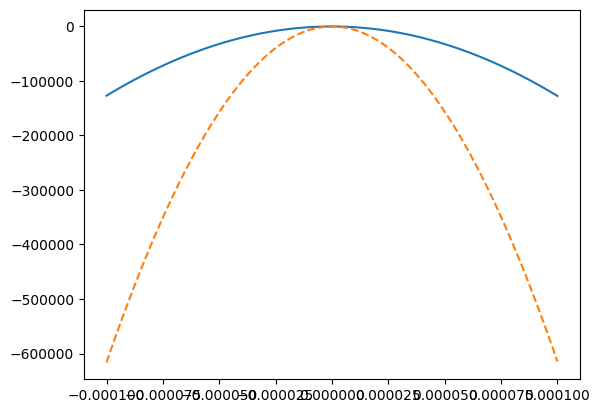

In [15]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["coalescence_time"] = mbhb_parameters["coalescence_time"] + np.linspace(-1e-4, 1e-4, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["coalescence_time"] = test_int_params["coalescence_time"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["coalescence_time"] - mbhb_parameters["coalescence_time"], test_F - np.max(test_F))
plt.plot(test_int_params["coalescence_time"] - mbhb_parameters["coalescence_time"], test_L - np.max(test_L), linestyle="--")

### test waveform and parameter recovery

In [16]:
int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    int_params.pop(key)
int_params

{'chirp_mass': 576197.9514630286,
 'mass_ratio': 0.5522574054088192,
 'spin_1z': 0.37355911773267536,
 'spin_2z': 0.00623924327101133,
 'coalescence_time': 11.274804346596925,
 'longitude': 1.8871744807025843,
 'latitude': 0.371115967075367}

In [17]:
rec_wave = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=int_params, 
    return_recovered_wave=True, 
)
rec_wave.shape

(3, 1, 21077)

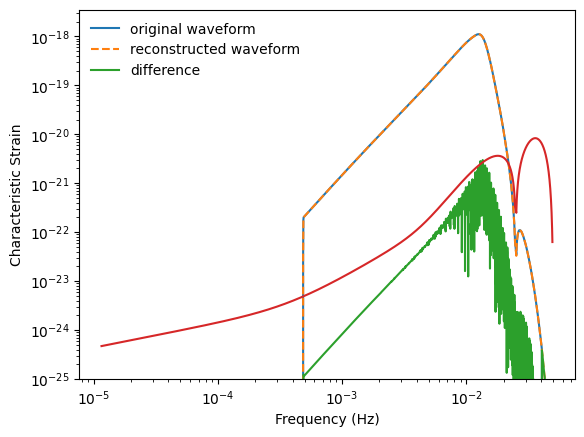

In [18]:
plt.loglog(data_frequencies, np.abs(wf_channels[0].get()) * data_frequencies, label="original waveform")
plt.loglog(data_frequencies, np.abs(rec_wave[0][0].get()) * data_frequencies, linestyle="--", label="reconstructed waveform")
plt.loglog(data_frequencies, np.abs(rec_wave[0][0].get() - wf_channels[0].get()) * data_frequencies, label="difference")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies))
plt.ylim(1e-25,)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")
plt.legend(loc="upper left", frameon=False)

In [19]:
rec_a = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=int_params, 
    return_a=True, 
)
rec_a.shape 

(1, 4)

In [20]:
rec_ext_params = Fstat.a_to_extrinsic(rec_a)
for k, v in rec_ext_params.items():
    print(k, v, mbhb_parameters[k])

luminosity_distance 18848.745690257027 18857.206212729037
inclination 2.2367724317241384 2.236968054828406
coalescence_phase 0.33776367483032527 5.6659961040911435
psi 0.1576424350814705 1.7289147577479866


### optimization from prior 

In [21]:
intrinsic_parameter_ranges = np.array([
    [5.5, 6.5], 
    [0.1, 1.], 
    [-0.99, 0.99], 
    [-0.99, 0.99], 
    [mbhb_parameters["coalescence_time"]-0.1, mbhb_parameters["coalescence_time"]+0.1], 
    [0, TWOPI], 
    [-1., 1.]
])

intrinsic_parameter_ranges

array([[ 5.5       ,  6.5       ],
       [ 0.1       ,  1.        ],
       [-0.99      ,  0.99      ],
       [-0.99      ,  0.99      ],
       [11.17480435, 11.37480435],
       [ 0.        ,  6.28318531],
       [-1.        ,  1.        ]])

In [22]:
from scipy.optimize import differential_evolution

n_dim_int = len(Fstatistics.intrinsic_parameter_names)
print("number of parameters to be optimized:", n_dim_int)

def cost_function(norm_int_params):
    """   
        norm_int_params: shape (Nparams, Nevent), normalized to (0, 1)
    """
    int_params = norm_int_params.transpose() * (intrinsic_parameter_ranges[:, 1] - intrinsic_parameter_ranges[:, 0]) + intrinsic_parameter_ranges[:, 0] # (Nevent, Nparams)
    params_in = Fstat.IntParamArr2ParamDict(int_params.transpose()) # (Nparams, Nevent) -> dictionary, each item (Nevent)
    return -Fstat.calculate_Fstat_vectorized(intrinsic_parameters=params_in) # (Nevent)

lower_bounds = np.zeros(n_dim_int) 
upper_bounds = np.ones(n_dim_int) 
bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

DE_result = differential_evolution(
    func=cost_function,
    bounds=bounds,
    x0=None,
    strategy='best1exp',
    # strategy='rand1bin',
    maxiter=5000,
    # popsize=10*n_dim_int,
    popsize=6*n_dim_int, 
    tol=1e-6,
    atol=1e-8,
    mutation=(0.4, 0.95),
    recombination=0.7,
    disp=False,
    polish=False,
    vectorized=True,
)
print(DE_result)

number of parameters to be optimized: 7


/home/ps/miniconda3/envs/tdc/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'vectorized' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


             message: Optimization terminated successfully.
             success: True
                 fun: -4042899.9758430263
                   x: [ 2.605e-01  5.037e-01  6.860e-01  5.079e-01
                        5.001e-01  2.980e-01  6.801e-01]
                 nit: 369
                nfev: 370
          population: [[ 2.605e-01  5.037e-01 ...  2.980e-01  6.801e-01]
                       [ 2.605e-01  5.047e-01 ...  2.983e-01  6.797e-01]
                       ...
                       [ 2.604e-01  5.015e-01 ...  2.979e-01  6.814e-01]
                       [ 2.605e-01  4.999e-01 ...  2.976e-01  6.849e-01]]
 population_energies: [-4.043e+06 -4.043e+06 ... -4.043e+06 -4.043e+06]


### reconstruct parameters and waveforms 

In [23]:
searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_parameter_ranges[:, 1] - intrinsic_parameter_ranges[:, 0]) + intrinsic_parameter_ranges[:, 0])

searched_a = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=searched_int_params, 
    return_a=True, 
) # (1, 4)
searched_ext_params = Fstat.a_to_extrinsic(searched_a)

searched_params = dict(searched_int_params, **searched_ext_params)

for k, v in searched_params.items():
    print(k, mbhb_parameters[k], np.abs(v-mbhb_parameters[k]))

chirp_mass 576197.9514630286 72.28160102490801
mass_ratio 0.5522574054088192 0.0010764112420778016
spin_1z 0.37355911773267536 0.005267816849909623
spin_2z 0.00623924327101133 0.009450804798678214
coalescence_time 11.274804346596925 2.680337811789002e-05
longitude 1.8871744807025843 0.014708980032920538
latitude 0.371115967075367 0.002598299348547717
luminosity_distance 18857.206212729037 141.4185599256889
inclination 2.236968054828406 0.0014983327336279828
coalescence_phase 5.6659961040911435 5.35131032469557
psi 1.7289147577479866 1.5552868563440834


(3, 1, 21077)

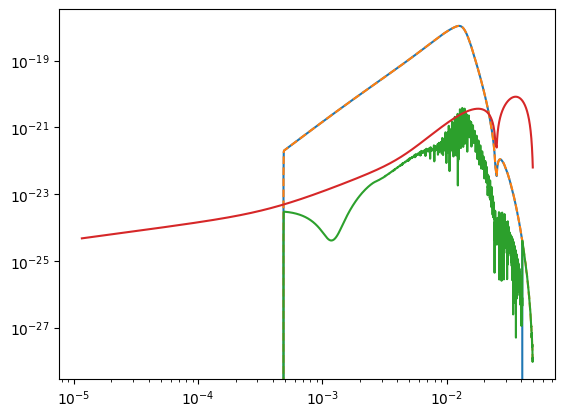

In [26]:
searched_wf = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=searched_int_params, 
    return_recovered_wave=True
)

plt.loglog(data_frequencies, np.abs(wf_channels[0].get()) * data_frequencies)
plt.loglog(data_frequencies, np.abs(searched_wf[0][0].get()) * data_frequencies, linestyle="--")
plt.loglog(data_frequencies, np.abs(searched_wf[0][0].get() - wf_channels[0].get()) * data_frequencies, linestyle="-")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies))

searched_wf.shape 

## Fisher analysis 

In [27]:
def fisher_waveform_wrapper(param_dict, frequencies):
    res = FDTDI_GPU.Response(
        parameters=param_dict, 
        freqs=xp.array(frequencies),  
        **response_kwargs_GPU, 
    )
    return res.get()

# set initial steps 
analyze_param_step_dict = {
    'chirp_mass': 10.,
    'mass_ratio': 0.01,
    'spin_1z': 0.01,
    'spin_2z': 0.01,
    'coalescence_time': 0.001,
    'coalescence_phase': 0.001,
    'luminosity_distance': 10.,
    'inclination': 0.01,
    'longitude': 0.01,
    'latitude': 0.01,
    'psi': 0.01
    }
for k, v in analyze_param_step_dict.items():
    analyze_param_step_dict[k] = -v 

FIM = MultiChannelFisher(
    waveform_generator=fisher_waveform_wrapper, 
    # param_dict=mbhb_parameters, 
    param_dict=searched_params, 
    analyze_param_step_dict=analyze_param_step_dict, 
    frequency=data_frequencies, 
    inverse_covariance=InvCovMat, 
    verbose=1,
)

FIM.auto_test_step()
FIM.calculate_Fisher()
FIM.calculate_errors() 

11 parameters in total: ['chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'longitude', 'latitude', 'luminosity_distance', 'inclination', 'coalescence_phase', 'psi']
11 analyzed parameters: ['chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'luminosity_distance', 'inclination', 'longitude', 'latitude', 'psi']
parameters whose steps should be tested: ['chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'luminosity_distance', 'inclination', 'longitude', 'latitude', 'psi']

 ========= testing parameter chirp_mass ==========
error = 3.171837898751092
shift = 5.0 relative diff = 2.0794007028984937e-06
shift of parameter chirp_mass is 5.0

 ========= testing parameter mass_ratio ==========
error = 0.009588404763591267
shift = 0.005 relative diff = 0.003546910083599256
error = 0.009554720777092606
shift = 0.0025 relative diff = 0.0044272526710117145
error = 0.009537954068461451
shift = 0.00125 

In [28]:
FIM.param_errors

{'chirp_mass': 66.8282964455139,
 'mass_ratio': 0.0026515927699313777,
 'spin_1z': 0.011538426649631296,
 'spin_2z': 0.022649214036836757,
 'coalescence_time': 9.37416073832496e-06,
 'coalescence_phase': 0.009525400020301722,
 'luminosity_distance': 63.483130913235726,
 'inclination': 0.005467668622687984,
 'longitude': 0.008730637165599233,
 'latitude': 0.00543335318520335,
 'psi': 0.009487228762767847}

## The 1st heterodyned search 

In [39]:
Like.prepare_het_log_like(base_parameters=ParamDict2ParamArr(searched_params)) # in realistic data analysis, the base parameters are usually not perfect coincident with truths

In [40]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove
from eryn.utils.utility import groups_from_inds
from eryn.backends import HDFBackend
from eryn.utils import SearchConvergeStopping

from corner import corner

In [41]:
truths = np.array(ParamDict2ParamArr(searched_params)) # actually the searched values 
ground_truths = np.array(ParamDict2ParamArr(mbhb_parameters))
labels = np.array(list(mbhb_parameters.keys()))
fim_range = []
for par in labels:
    if par in ["chirp_mass", "luminosity_distance"]:
        ran = FIM.param_errors[par] / searched_params[par] # log value 
    else:
        ran = FIM.param_errors[par] # we donot process the sin/cos values since they will not be used 
    fim_range.append(ran)
fim_range = np.array(fim_range) * 20. # ~20 sigmas

for idx, par in enumerate(labels):
    print(par, truths[idx], fim_range[idx])

chirp_mass 5.7605172260875825 0.00231992080691426
mass_ratio 0.553333816650897 0.05303185539862755
spin_1z 0.36829130088276574 0.23076853299262592
spin_2z 0.015690048069689544 0.45298428073673513
coalescence_time 11.274831149975043 0.00018748321476649922
coalescence_phase 0.3146857793955738 0.19050800040603444
luminosity_distance 4.2787221654126615 0.06682918545200056
inclination -0.6191580462912697 0.10935337245375967
longitude 1.8724655006696638 0.17461274331198468
latitude 0.3602330162671785 0.10866706370406701
psi 0.1736279014039032 0.18974457525535696


In [42]:
# set hyper parameters
ndim = 11 # dimension of paramters 
nwalkers = 400 # number of random walkers, more walkers can be used since heterodyned likelihood requires much less vRAM, 400 is a quite large number for this task 
ntemps = 10 # number of temperatures used in parallel tempering 
temps = np.array(list(np.power(2., np.arange(ntemps - 1))) + [np.infty]) 
betas = 1. / temps 
tempering_kwargs=dict(betas=betas)

mcmc_moves = StretchMove(a=2) # emcee move 

stop = None 

# set a narrower prior for the instrinsic parameters, since heterodyned likelihood must be based on an initial estimation 
lim_lgMc = [truths[0] - fim_range[0], truths[0] + fim_range[0]]
lim_q = [max(0.1, truths[1] - fim_range[1]), min(1., truths[1] + fim_range[1])]
lim_chiz1 = [max(-0.99, truths[2] - fim_range[2]), min(0.99, truths[2] + fim_range[2])]
lim_chiz2 = [max(-0.99, truths[3] - fim_range[3]), min(0.99, truths[3] + fim_range[3])]
lim_tc = [truths[4] - fim_range[4], truths[4] + fim_range[4]] # assume a preliminary search step to locate the merger within 1000s
lim_phic = [0, TWOPI]
lim_lgD = [truths[6]-fim_range[6], truths[6]+fim_range[6]]
lim_cosinc = [-1, 1]
lim_lam = [0, TWOPI]
lim_sinbeta = [-1, 1]
lim_psi = [0, PI]

lims = np.array([lim_lgMc, lim_q, lim_chiz1, lim_chiz2, lim_tc, lim_phic, lim_lgD, lim_cosinc, lim_lam, lim_sinbeta, lim_psi])
lower_lims = lims[:, 0]
upper_lims = lims[:, 1]

priors_in = {i: uniform_dist(lims[i][0], lims[i][1]) for i in range(ndim)}
priors = ProbDistContainer(priors_in)
priors.use_cupy = False

# set starting range 
# start_lims = np.array(truths)[:, np.newaxis] + np.array([-1e-3, 1e-3])
start_lims = lims.copy()
start_priors_in = {i: uniform_dist(start_lims[i][0], start_lims[i][1]) for i in range(ndim)}
start_priors = ProbDistContainer(start_priors_in)
start_priors.use_cupy = False

lims, start_lims

(array([[ 5.75819731,  5.76283715],
        [ 0.50030196,  0.60636567],
        [ 0.13752277,  0.59905983],
        [-0.43729423,  0.46867433],
        [11.27464367, 11.27501863],
        [ 0.        ,  6.28318531],
        [ 4.21189298,  4.34555135],
        [-1.        ,  1.        ],
        [ 0.        ,  6.28318531],
        [-1.        ,  1.        ],
        [ 0.        ,  3.14159265]]),
 array([[ 5.75819731,  5.76283715],
        [ 0.50030196,  0.60636567],
        [ 0.13752277,  0.59905983],
        [-0.43729423,  0.46867433],
        [11.27464367, 11.27501863],
        [ 0.        ,  6.28318531],
        [ 4.21189298,  4.34555135],
        [-1.        ,  1.        ],
        [ 0.        ,  6.28318531],
        [-1.        ,  1.        ],
        [ 0.        ,  3.14159265]]))

In [43]:
def eryn_like(params): 
    """params: numpy array of shape (Nevents, Nparams)"""
    # return Like.full_log_like_vectorized(np.transpose(params))
    return Like.het_log_like_vectorized(np.transpose(params))

In [44]:
ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    eryn_like, 
    priors,
    args=[],
    tempering_kwargs=tempering_kwargs,
    stopping_fn=stop,
    stopping_iterations=10,
    moves=mcmc_moves,
    vectorize=True,
)

In [95]:
# randomize starting positions throughout prior
coords = start_priors.rvs(size=(ntemps, nwalkers,))
print(coords.shape)

thin_by = 100 
burn = 0
nsteps = int(100000 / thin_by) # should be more than enough 

ensemble.stopping_fn = None

out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)

(10, 200, 11)
eryn: Exception while calling your likelihood function:
  args added: [array([[ 5.58342714e+00,  8.78873887e-01,  7.18109118e-01, ...,
         8.60806956e-01, -9.30977341e-01,  5.84710140e-04],
       [ 5.58406617e+00,  9.85653861e-01,  2.02103265e-01, ...,
         1.71584769e+00,  1.20201791e-02,  2.60356749e+00],
       [ 5.57757971e+00,  9.22640577e-01,  9.55084842e-01, ...,
         1.19365581e+00, -8.09560033e-01,  2.70422209e+00],
       ...,
       [ 5.58298602e+00,  9.01652762e-01,  9.17921347e-01, ...,
         3.59875563e+00,  2.94401487e-01,  2.36893164e+00],
       [ 5.58368084e+00,  9.52909945e-01,  7.36723999e-01, ...,
         5.55453528e+00, -7.86118957e-02,  1.81579172e+00],
       [ 5.58566551e+00,  8.98036442e-01,  1.94144918e-01, ...,
         2.80110174e-01,  5.52309234e-01,  1.99571983e+00]])]
  args: []
  kwargs added: {}
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/eryn/ensemble.py", line 1644, in __call__
    out = self.f(*args_in, **kwargs_in)
  File "/tmp/ipykernel_196458/3626440450.py", line 4, in eryn_like
    return Like.het_log_like_vectorized(np.transpose(params))
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Utils.py", line 322, in het_log_like_vectorized
    het_h = self.xp.transpose(self.response_generator.Response(
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Response.py", line 1093, in Response
    _, GTDI = self.TransferFunction(t=tgrids[mode], f=fgrids, k=k, Plm=Plm[mode], TDIGeneration=TDIGeneration, tmin=tmin, tmax=tmax)
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Response.py", line 797, in TransferFunction
    p1 = self.xp.array([
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/cupy/_creation/from

OutOfMemoryError: Out of memory allocating 49,152,000 bytes (allocated so far: 4,188,331,520 bytes).

In [ ]:
thin = 10
burnin = 0
len_chain = len(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, 0, :, 0])

plt.figure()
fig, ax = plt.subplots(ndim, 1)
fig.set_size_inches(10, 3*ndim)
for i in range(ndim):     
    for walk in range(20): # plot 20 walkers 
        ax[i].plot(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, walk, 0, i])
        ax[i].hlines(ground_truths[i], 0, len_chain, color='k', linestyle='-.', linewidth=0.8)
    ax[i].set_ylabel(labels[i])
# plt.savefig("MCMC_trajectory_het.jpg", dpi=360)

In [ ]:
burnin=200
thin = 10

samp = ensemble.get_chain(discard=burnin, thin=thin)['model_0'][:, 0, :, :, :].reshape(-1, ndim)
print("sample shape:", samp.shape)

plt.figure()
corner(
    samp, bins=50, color=BLUE, 
    labels=labels, label_kwargs={'fontsize': 14}, 
    # range=lims,
    truths=ground_truths, truth_color=RED, 
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={'fontsize':14},
    levels = (1. - np.exp(-1.**2/2), 1. - np.exp(-2.**2/2), 1. - np.exp(-3.**2/2)),
    smooth=0.9, # default for bilby: smooth = 0.9, bins = 50 
    plot_density=True, # whether to show the density of samples with colors 
    plot_datapoints=False, # whether to plot individual data points 
    fill_contours=True, # whether to fill the corners 
    );
# plt.savefig("MCMC_corner_het.jpg", dpi=360)
# np.save("chain_het.npy", samp)